## Topic modeling

- https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
- http://www.engear.net/wp/topic-modeling-gensimpython/
- a type of statistical modeling for discovering the abstract "topics" that occur in a collection of documents.

### Latent Dirichlet Allocation
- an example of topic model and used to classify text in a document to a particular topic
- it builds a topic per document model and words per topic model, modeled as Dirichlet distributions

In [123]:
import pandas as pd
import numpy as np

data = pd.read_csv('titles.csv', delimiter='\t', error_bad_lines=True, header=None)
data.columns = ['id', 'title']
data.title = data.title.str.strip()
documents = data
documents['title'].replace('', np.nan, inplace=True)
documents.dropna(subset=['title'], inplace=True)
documents.head()

,id,title
0,4105,Baseline characteristics
1,4106,Analysis of efficacy
2,4107,Comparisons of postoperative CA19-9 levels on ...
3,4108,Pattern of disease relapse
4,4109,Grade 1–5 adverse events with gemcitabine alon...


#### Data Pre-processing
- tokenization: split the text into sentences and the sentences into words. Lowercase the words and remove punctuation
- words that have fewer than 3 characters are removed.
- all stopwords are removed.
- words are lemmatized(verbs in past and future tenses are changed into present)
- words are stemmed(words are reduced to their root form)

In [5]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import strip_numeric
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [6]:
np.random.seed(2018)

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/grace/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [121]:
stemmer = SnowballStemmer('english')
stop_words = list(gensim.parsing.preprocessing.STOPWORDS)
#can add custom stop words
stop_words.extend(['table'])

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

#글자길이가 3보다 작으면 제외
def preprocess(text):
    result = []
#     deacc=True removes punctuations
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in stop_words and len(token)>3:
            result.append(lemmatize_stemming(strip_numeric(token)))
    return result

In [122]:
#preview after preprocessing
doc_sample = documents.loc[100].title

print('original document')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)

print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document
['Patients’', 'Characteristics', 'and', 'Hospitalization', 'or', 'Clinic', 'Visits', 'During', 'Follow-Up']


 tokenized and lemmatized document: 
['patient', 'characterist', 'hospit', 'clinic', 'visit', 'follow']


In [10]:
documents = documents.astype(str)
#process the text, save the results as processed_docs
processed_docs = documents.title.map(preprocess)
processed_docs[:10]

0                              [baselin, characterist]
1                                  [analysi, efficaci]
2    [comparison, postop, level, surviv, espac, con...
3                            [pattern, diseas, relaps]
4    [grade, advers, event, gemcitabin, gemcitabin,...
5                              [baselin, characterist]
6                          [treatment, zoledron, acid]
7                               [treatment, docetaxel]
8       [treatment, relaps, discret, treat, clinician]
9    [worst, advers, event, grade, report, entir, t...
Name: title, dtype: object

#### Bigram & Trigram
- http://www.engear.net/wp/topic-modeling-gensimpython/
- implement n-grams with Gensim Phrases
- min_count : ignore all words and bigrams with total collected count lower than this value 
- threshold : represent a score threshold for forming the phrases (higher means fewer phrases)

In [124]:
#bigram and trigram models
bigram = gensim.models.Phrases(processed_docs, min_count=100, threshold=500)
trigram = gensim.models.Phrases(bigram[processed_docs], threshold=500)

#sentence clubbed as a trigram/bigram


#### bag of words on the data set
- create a dictionary from 'processed_docs' containing the number of times a word appears in the training set

In [11]:
dictionary = gensim.corpora.Dictionary(processed_docs)

count = 0
for k, v in dictionary.iteritems():
    print(k,v)
    count += 1
    if count > 20:
        break

0 baselin
1 characterist
2 analysi
3 efficaci
4 comparison
5 conoko
6 espac
7 jaspac
8 level
9 postop
10 surviv
11 trial
12 diseas
13 pattern
14 relaps
15 advers
16 capecitabin
17 event
18 gemcitabin
19 grade
20 plus


In [94]:
# filter out tokens that appear in less than 0.1 documents 
# or more than 0.5 documents
# after above, keep only the first 100000 most frequent tokens.

dictionary.filter_extremes(no_below=0.1, no_above=0.5, keep_n=100000)

In [95]:
# gensim doc2bow
# for each document, create a dictionary reporting how many words and how many times those words appear
# save to 'bow_corpus'

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[100]

[(1, 1), (98, 1), (186, 1), (226, 1), (264, 1), (269, 1)]

In [96]:
# preview bag of words for sample processed document

bow_doc_100 = bow_corpus[100]

for i in range(len(bow_doc_100)):
    print("Word {} (\"{}\") appears {} times.".format(bow_doc_100[i][0],
                                                     dictionary[bow_doc_100[i][0]],
                                                     bow_doc_100[i][1]))

Word 1 ("characterist") appears 1 times.
Word 98 ("patient") appears 1 times.
Word 186 ("follow") appears 1 times.
Word 226 ("clinic") appears 1 times.
Word 264 ("hospit") appears 1 times.
Word 269 ("visit") appears 1 times.


#### TF-IDF
- tf-idf model on bow_corpus
- apply transformation to the entire corpus and call it 'corpus_tfidf'


- tf = count(word, document) / len(document)
- idf = log( len(collection) / count(document_containing_term, collection)
- tf-idf = tf * idf

In [97]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.7887988885712802), (1, 0.6146513754875305)]


### LDA using bag of words

- train LDA using gensim.models.LdaMulticore

In [98]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [99]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.020*"chang" + 0.017*"mean" + 0.016*"analysi" + 0.015*"measur" + 0.013*"valu" + 0.013*"result" + 0.011*"variabl" + 0.011*"baselin" + 0.011*"score" + 0.011*"data"
Topic: 1 
Words: 0.150*"characterist" + 0.099*"baselin" + 0.078*"patient" + 0.040*"clinic" + 0.030*"demograph" + 0.026*"studi" + 0.015*"leav" + 0.014*"popul" + 0.014*"ventricular" + 0.012*"group"
Topic: 2 
Words: 0.033*"risk" + 0.019*"factor" + 0.019*"multivari" + 0.018*"associ" + 0.017*"year" + 0.017*"death" + 0.017*"mortal" + 0.016*"analysi" + 0.015*"ratio" + 0.015*"model"
Topic: 3 
Words: 0.046*"treatment" + 0.046*"event" + 0.038*"advers" + 0.037*"outcom" + 0.035*"patient" + 0.024*"group" + 0.016*"cancer" + 0.014*"relat" + 0.013*"primari" + 0.011*"studi"
Topic: 4 
Words: 0.027*"patient" + 0.020*"treat" + 0.017*"respons" + 0.016*"intent" + 0.016*"popul" + 0.014*"coronari" + 0.014*"summari" + 0.013*"event" + 0.013*"myocardi" + 0.012*"infarct"


- run LDA using TF-IDF

In [100]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [101]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"patient" + 0.010*"data" + 0.009*"ventricular" + 0.008*"hemodynam" + 0.007*"leav" + 0.006*"mutat" + 0.006*"blood" + 0.006*"pressur" + 0.006*"function" + 0.006*"clinic"
Topic: 1 Word: 0.107*"characterist" + 0.098*"baselin" + 0.050*"patient" + 0.042*"advers" + 0.039*"demograph" + 0.037*"event" + 0.029*"clinic" + 0.025*"popul" + 0.025*"studi" + 0.019*"treatment"
Topic: 2 Word: 0.011*"risk" + 0.007*"factor" + 0.006*"subject" + 0.006*"year" + 0.006*"diabet" + 0.006*"associ" + 0.005*"studi" + 0.005*"women" + 0.005*"featur" + 0.005*"treatment"
Topic: 3 Word: 0.027*"outcom" + 0.015*"secondari" + 0.013*"primari" + 0.013*"analysi" + 0.012*"surviv" + 0.012*"multivari" + 0.011*"treatment" + 0.010*"year" + 0.010*"respons" + 0.010*"mortal"
Topic: 4 Word: 0.008*"coronari" + 0.007*"toxic" + 0.007*"arteri" + 0.007*"patient" + 0.007*"effect" + 0.006*"diseas" + 0.006*"treatment" + 0.005*"heart" + 0.005*"group" + 0.004*"vaccin"


#### performance evaluation by classifying sample document using LDA bag of words model

In [102]:
documents.loc[documents['title'].str.find('adverse')>=0][:10]

,id,title
4,4109,Grade 1–5 adverse events with gemcitabine alon...
9,4115,Worst adverse event (grade) reported over enti...
28,4134,Serious adverse events related to hypotension
32,4138,"Association of birthweight, conditional relati..."
36,4142,Grade 3 or 4 adverse events
45,4151,Serious adverse events by treatment and body s...
234,4339,30-Day Clinical Outcomes: Clopidogrel Versus T...
331,4436,Clinical Events Data presented are number of p...
333,4438,Predictors for Occurrence of Major Adverse Car...
1516,5640,Mean Costs and Added Costs Added costs report ...


In [103]:
processed_docs[45]

['advers', 'event', 'treatment', 'bodi', 'affect']

In [104]:
for ind, score in sorted(lda_model[bow_corpus[45]], key=lambda x: -1*x[1]):
    print('\nScore: {}\t \nTopic: {}'.format(score, lda_model.print_topic(ind, 10)))


Score: 0.7108096480369568	 
Topic: 0.046*"treatment" + 0.046*"event" + 0.038*"advers" + 0.037*"outcom" + 0.035*"patient" + 0.024*"group" + 0.016*"cancer" + 0.014*"relat" + 0.013*"primari" + 0.011*"studi"

Score: 0.18724565207958221	 
Topic: 0.020*"chang" + 0.017*"mean" + 0.016*"analysi" + 0.015*"measur" + 0.013*"valu" + 0.013*"result" + 0.011*"variabl" + 0.011*"baselin" + 0.011*"score" + 0.011*"data"

Score: 0.0342358835041523	 
Topic: 0.033*"risk" + 0.019*"factor" + 0.019*"multivari" + 0.018*"associ" + 0.017*"year" + 0.017*"death" + 0.017*"mortal" + 0.016*"analysi" + 0.015*"ratio" + 0.015*"model"

Score: 0.03405143693089485	 
Topic: 0.027*"patient" + 0.020*"treat" + 0.017*"respons" + 0.016*"intent" + 0.016*"popul" + 0.014*"coronari" + 0.014*"summari" + 0.013*"event" + 0.013*"myocardi" + 0.012*"infarct"

Score: 0.03365737572312355	 
Topic: 0.150*"characterist" + 0.099*"baselin" + 0.078*"patient" + 0.040*"clinic" + 0.030*"demograph" + 0.026*"studi" + 0.015*"leav" + 0.014*"popul" + 0.01

#### performance evaluation by classifying sample document using LDA TF-IDF model

In [105]:
for ind, score in sorted(lda_model_tfidf[bow_corpus[45]], key=lambda x: -1*x[1]):
    print('\nScore: {}\t \nTopic: {}'.format(score, lda_model_tfidf.print_topic(ind, 10)))


Score: 0.489359587430954	 
Topic: 0.107*"characterist" + 0.098*"baselin" + 0.050*"patient" + 0.042*"advers" + 0.039*"demograph" + 0.037*"event" + 0.029*"clinic" + 0.025*"popul" + 0.025*"studi" + 0.019*"treatment"

Score: 0.40757057070732117	 
Topic: 0.008*"coronari" + 0.007*"toxic" + 0.007*"arteri" + 0.007*"patient" + 0.007*"effect" + 0.006*"diseas" + 0.006*"treatment" + 0.005*"heart" + 0.005*"group" + 0.004*"vaccin"

Score: 0.0347069688141346	 
Topic: 0.011*"risk" + 0.007*"factor" + 0.006*"subject" + 0.006*"year" + 0.006*"diabet" + 0.006*"associ" + 0.005*"studi" + 0.005*"women" + 0.005*"featur" + 0.005*"treatment"

Score: 0.034323517233133316	 
Topic: 0.010*"patient" + 0.010*"data" + 0.009*"ventricular" + 0.008*"hemodynam" + 0.007*"leav" + 0.006*"mutat" + 0.006*"blood" + 0.006*"pressur" + 0.006*"function" + 0.006*"clinic"

Score: 0.034039393067359924	 
Topic: 0.027*"outcom" + 0.015*"secondari" + 0.013*"primari" + 0.013*"analysi" + 0.012*"surviv" + 0.012*"multivari" + 0.011*"treatment

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5,1,'topic 1')

Text(0.5,0,'probability')

Text(0.5,1,'topic 2')

Text(0.5,0,'probability')

Text(0.5,1,'topic 3')

Text(0.5,0,'probability')

Text(0.5,1,'topic 4')

Text(0.5,0,'probability')

Text(0.5,1,'topic 5')

Text(0.5,0,'probability')

IndexError: index 5 is out of bounds for axis 0 with size 5

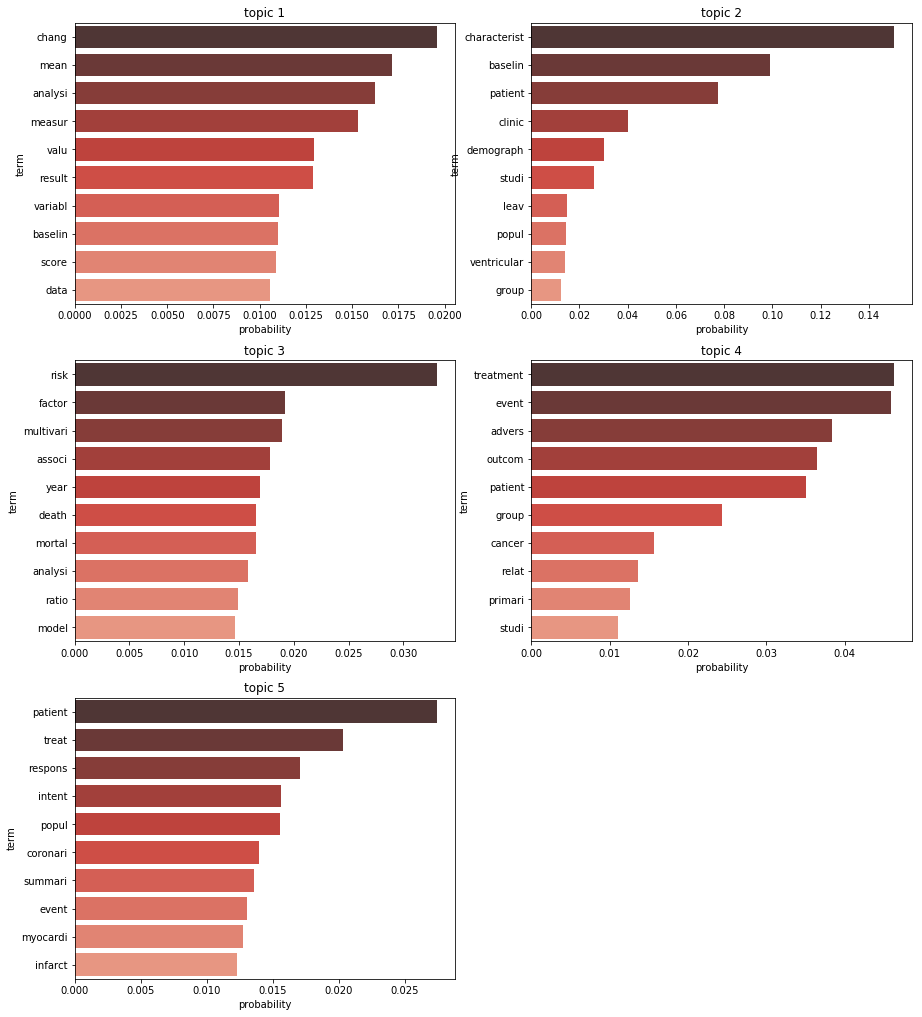

In [107]:
fiz=plt.figure(figsize=(15,30))

for i in range(9):
    df=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, palette='Reds_d')
    plt.xlabel('probability')
    

plt.show()

In [ ]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [ ]:
data = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
data
#each bubble = topic, the larger the bubble, the more prevalent is that topic
#good topic = fairly big, non-overlapping bubbles scattered throughout the chart
#model with too many topics = typically have many overlaps, small sized bubbles in one region of the chart

#bar = salient keywords that form the selected topic

In [ ]:
pyLDAvis.save_html(data, 'vis.html')

In [ ]:
# https://github.com/JasonKessler/Scattertext-PyDatab

#### Perplexity and Coherence score
- model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is

In [108]:
#compute perplexity : a measure of how good the model is
# lower the better
print('\nPerplexit: ', lda_model.log_perplexity(bow_corpus))


Perplexit:  -6.819606213414746


In [109]:
from gensim.models import CoherenceModel

#compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.392775332001609


In [110]:
#is mallet better?
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=bow_corpus, num_topics=10, id2word=dictionary)

In [111]:
#show topics
pprint(lda_mallet.show_topics(formatted=False))

#compute coherenece score
coherence_lda_mallet = CoherenceModel(model=lda_mallet, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherenece_lda_m = coherence_lda_mallet.get_coherence()
print('\nCoherence Score: ', coherenece_lda_m)

[(0,
  [('coronari', 0.07088727943849445),
   ('patient', 0.054500713067307964),
   ('diseas', 0.05357792008053466),
   ('arteri', 0.046950588630071864),
   ('myocardi', 0.035765219093425796),
   ('data', 0.03501020664970219),
   ('procedur', 0.034870389530494116),
   ('infarct', 0.03185033975559968),
   ('angiograph', 0.02720841139789156),
   ('acut', 0.01602304186124549)]),
 (1,
  [('year', 0.07177373507674815),
   ('rat', 0.02930642410460489),
   ('number', 0.023848777714610574),
   ('estim', 0.021773735076748152),
   ('women', 0.021119954519613418),
   ('effect', 0.020807276861853324),
   ('health', 0.01665719158612848),
   ('status', 0.016515065378055714),
   ('preval', 0.016287663445139284),
   ('children', 0.014752700397953383)]),
 (2,
  [('characterist', 0.34008362012571464),
   ('baselin', 0.23527404078614295),
   ('clinic', 0.11172103870986091),
   ('patient', 0.09804033106743651),
   ('demograph', 0.05859097243948918),
   ('studi', 0.05190705082624648),
   ('particip', 0.034

#### Optimal number of topics
- build many LDA models with different values of number of topics and pick the one that gives the highest coherence value
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

In [112]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    compute c_v coherence for various number of topics
    
    parameters:
    dictionary : gensim dictionary
    corpus : gensim corpus
    texts : list of input texts
    limit : max number of topics
    
    returns:
    model_list : list of LDA topic models
    coherence_values : coherence value
    """
    
    coherenece_values = []
    u_mass_coherenece_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=bow_corpus, \
                                                 num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        u_mass_coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        
        coherenece_values.append(coherence_model.get_coherence())
        u_mass_coherenece_values.append(u_mass_coherence_model.get_coherence())

    return model_list, coherenece_values, u_mass_coherenece_values

In [113]:
model_list, coherence_values, umass_co_val = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, \
                                                       texts=processed_docs, start=2, limit=15, step=1)

<Figure size 1080x720 with 0 Axes>

Text(0.5,0,'Number of Topics')

Text(0,0.5,'Coherence score')

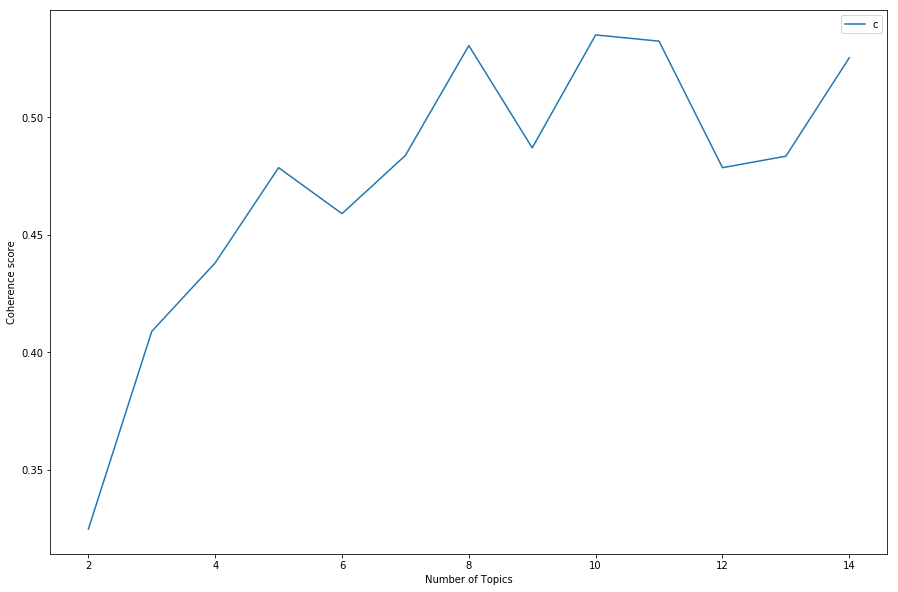

In [114]:
#graph
plt.figure(figsize=(15,10))

limit = 15; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

<Figure size 1080x720 with 0 Axes>

Text(0.5,0,'Number of Topics')

Text(0,0.5,'u mass Coherence score')

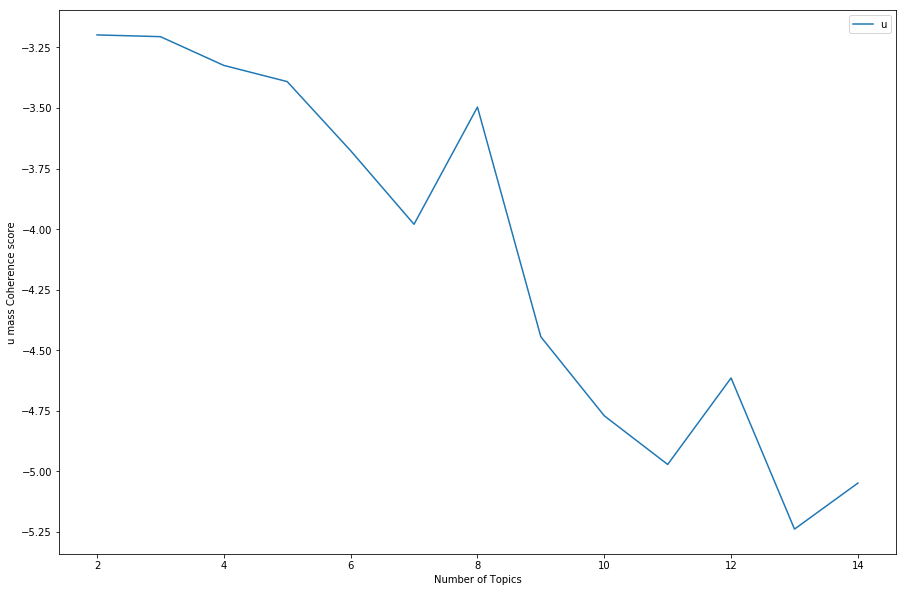

In [115]:
#graph
plt.figure(figsize=(15,10))

limit = 15; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, umass_co_val)
plt.xlabel("Number of Topics")
plt.ylabel("u mass Coherence score")
plt.legend(("u mass coherence_values"), loc="best")
plt.show()

In [116]:
# Print the coherence scores
# one that maximizes the topic coherence
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3246
Num Topics = 3  has Coherence Value of 0.4089
Num Topics = 4  has Coherence Value of 0.438
Num Topics = 5  has Coherence Value of 0.4786
Num Topics = 6  has Coherence Value of 0.459
Num Topics = 7  has Coherence Value of 0.4838
Num Topics = 8  has Coherence Value of 0.5306
Num Topics = 9  has Coherence Value of 0.487
Num Topics = 10  has Coherence Value of 0.5351
Num Topics = 11  has Coherence Value of 0.5325
Num Topics = 12  has Coherence Value of 0.4786
Num Topics = 13  has Coherence Value of 0.4835
Num Topics = 14  has Coherence Value of 0.5254


In [117]:
# Print the coherence scores
for m, um in zip(x, umass_co_val):
    print("Num Topics =", m, " has Coherence Value of", round(um, 4))

Num Topics = 2  has Coherence Value of -3.1984
Num Topics = 3  has Coherence Value of -3.2056
Num Topics = 4  has Coherence Value of -3.3243
Num Topics = 5  has Coherence Value of -3.3911
Num Topics = 6  has Coherence Value of -3.6763
Num Topics = 7  has Coherence Value of -3.9799
Num Topics = 8  has Coherence Value of -3.4962
Num Topics = 9  has Coherence Value of -4.4445
Num Topics = 10  has Coherence Value of -4.7704
Num Topics = 11  has Coherence Value of -4.9713
Num Topics = 12  has Coherence Value of -4.6144
Num Topics = 13  has Coherence Value of -5.2381
Num Topics = 14  has Coherence Value of -5.0482
